In [1]:
'''started on 09/16/2025'''

'started on 09/16/2025'

In [1]:
'''last updated on 09/18/2025
update heatmap to SW, LW, total separately'''

'last updated on 09/18/2025\nupdate heatmap to SW, LW, total separately'

In [3]:
'''Images must be provided at final size, preferably 1 column width (8.7cm). Figures wider than 1 column should be sized to 11.4cm or 17.8cm wide. Numbers, letters, and symbols should be no smaller than 6 points (2mm) and no larger than 12 points (6mm) after reduction and must be consistent.'''

'Images must be provided at final size, preferably 1 column width (8.7cm). Figures wider than 1 column should be sized to 11.4cm or 17.8cm wide. Numbers, letters, and symbols should be no smaller than 6 points (2mm) and no larger than 12 points (6mm) after reduction and must be consistent.'

# import

In [2]:
import sys
sys.path.append("/glade/u/home/geethma/phd_research_home/functions")
from imports import *


ERROR 1: PROJ: proj_create_from_database: Open of /glade/u/home/geethma/.conda/envs/wgh/share/proj failed


In [3]:
import tol_colors as tc
from matplotlib.colors import LinearSegmentedColormap
from seaborn import palplot
import pyplot_themes as themes

In [4]:
from my_binned import *
from lat_weight_mean import lat_weight_mean
from load_xarray import *
from TOAf import *
from cyclone_obs import *
from cyclone_metrics import *

In [5]:
# PNAS font sizes
title_fontsize = 8
label_fontsize = 7
tick_fontsize = 6

In [6]:
fig_dir = '/glade/derecho/scratch/geethma/figures_GFB/'

# data load

In [7]:
var_list = ['dPE_maps_gol', 'dSWCREmap', 'dTSmap_gol', 'wvp_maps_ol', 'w500_maps_ol', 'dLWPmap_gol', 'pe_maps_ol']
var_dict = {var: load_xarray(var) for var in var_list}

### Select only common runs for all datasets
var_keys = list(var_dict.keys())
common_members = var_dict[var_keys[0]]["runs"].values
for name in var_keys:
    print(name)
    common_members = np.intersect1d(common_members, var_dict[name]["runs"].values)

var_dict = {name: ds.sel(runs=common_members) for name, ds in var_dict.items()}

dPE_maps_gol
dSWCREmap
dTSmap_gol
wvp_maps_ol
w500_maps_ol
dLWPmap_gol
pe_maps_ol


In [8]:
dGMT = lat_weight_mean(var_dict['dTSmap_gol'])[0]

In [28]:
# cloud feedback
files = sorted(glob.glob(
    "/glade/derecho/scratch/travisa/CAM6_kernels/member_number_*/CAM6_PPE_CRK_decomp_all_pressure_all_cloud.nc"
))

def drop_object_vars_and_coords(ds):
    obj_vars = [v for v in ds.data_vars if ds[v].dtype == object]  # Drop object dtype data variables
    obj_coords = [c for c in ds.coords if ds[c].dtype == object]  # Drop object dtype coordinates too
    to_drop = obj_vars + obj_coords
    if to_drop:
        ds = ds.drop_vars(to_drop)
    return ds

cf = xr.open_mfdataset(
    files,
    combine="nested",
    concat_dim="runs",
    preprocess=drop_object_vars_and_coords,
    chunks={},             # disable auto rechunking
    parallel=False         # avoid Dask auto-guessing memory
)

cf = cf.assign_coords(runs=range(len(files)))
cf_mean = cf.mean(dim="time")

# Shift longitude from [0, 360) to [-180, 180)
cf_mean = cf_mean.assign_coords(
    lon=(((cf_mean.lon + 180) % 360) - 180)
)  
cf_mean = cf_mean.sortby("lon")
cf_mean = cf_mean.transpose("runs", "lat", "lon")  # reorder dimensions explicitly: runs, lat, lon

totdCRE_g = (cf_mean['LWcld_tot']+cf_mean['SWcld_tot'])/dGMT  #[Wm-2K-1]  total CF
# totdCRE_g = (cf_mean['LWcld_tot'])/dGMT  #[Wm-2K-1]  LW component
# totdCRE_g = (cf_mean['SWcld_tot'])/dGMT  #[Wm-2K-1]  SW component
common_members = np.intersect1d(common_members, totdCRE_g["runs"].values)
totdCRE_g = totdCRE_g.sel(runs=common_members)

In [11]:
dLWP_g = var_dict['dLWPmap_gol']/dGMT  #[kgm-2K-1]
dLWP_g = dLWP_g.sel(runs=common_members)

In [12]:
dPE_p = var_dict['dPE_maps_gol']*86400/dGMT  #[kgm-2day-1K-1]
dPE_p = dPE_p.sel(runs=common_members)

In [13]:
wvp_g = var_dict['wvp_maps_ol']  #[kgm-2]
wvp_g = wvp_g.sel(runs=common_members)

In [14]:
w500_g = var_dict['w500_maps_ol']  #[Pas-1]
w500_g = w500_g.sel(runs=common_members)

In [15]:
pe_maps_ol = var_dict['pe_maps_ol']*86400  #[kgm-2day-1]
pe_maps_ol = pe_maps_ol.sel(runs=common_members)

In [16]:
file = np.load('/glade/derecho/scratch/cisong/backup_FOR_wyom0124/variables_filtered/pe.npz')
PE_g_mean = xr.DataArray(file['data'], dims=['runs'], coords={'runs':file['runs']})  
PE_g_mean = PE_g_mean.sel(runs=common_members)  # [s-1]

In [17]:
PPE_grad_LWP_WCB, PPE_grad_LWP_PRC = cyclone_metrics()
PPE_grad_LWP_PRC = PPE_grad_LWP_PRC.sel(runs=common_members)
PPE_grad_LWP_WCB = PPE_grad_LWP_WCB.sel(runs=common_members)

In [18]:
### TOA means
TOA = TOAf()
filtered_TOA_15 = TOA.where((TOA >= TOA[0] - 15) & (TOA <= TOA[0] + 15), drop=True)

In [19]:
## cyclone observations
from cyclone_obs import *
obs_dict = cyclone_obs()

# updated figure - heatmap of ∆P-E/∆T and kernel total CF with omega500 and wvp

In [20]:
'get the 2D binned statistic'
### get the 2D binned statistic
### (x, y, z - all in 1D array)
def twodbin(x_95, y_95, z_95, bins=[10,12], n_bins=150, bin_range=[[-0.06, 0.06], [5, 50]]):
    ind = np.isnan(x_95*y_95*z_95)==False
    bins_cnt = stats.binned_statistic_2d(y_95[ind], x_95[ind], z_95[ind], 
                                         bins=bins, statistic='count', range=bin_range)[0]
    bins = stats.binned_statistic_2d(y_95[ind], x_95[ind], z_95[ind], 
                                     bins=bins, range=bin_range)
    
    y_f = list(reversed(find_midpoints(bins[1]))) #length 10
    x_f = find_midpoints(bins[2]) #length 12
    z_f = list(reversed(bins[0]))
    z_f = np.array(z_f)
    c = list(reversed(bins_cnt))
    c = np.array(c)
    c_ind = np.where(c<n_bins)
    c[c_ind] = np.nan
    z_f[c_ind] = np.nan
    return x_f, y_f, z_f, c

def find_midpoints(bins):
    midpoints = (bins[:-1] + bins[1:]) / 2
    return midpoints


/glade/derecho/scratch/geethma/tmp/ipykernel_73017/994076048.py:25: RuntimeWarning: Mean of empty slice
  h_dlwp_mean = np.nanmean(np.array(h_dlwp_list), axis=0)
/glade/derecho/scratch/geethma/tmp/ipykernel_73017/994076048.py:26: RuntimeWarning: Mean of empty slice
  h_c_mean = np.nanmean(np.array(h_c_list), axis=0)
/glade/derecho/scratch/geethma/tmp/ipykernel_73017/994076048.py:93: RuntimeWarning: Mean of empty slice
  h_dlwp_mean = np.nanmean(np.array(h_dlwp_list), axis=0)
/glade/derecho/scratch/geethma/tmp/ipykernel_73017/994076048.py:94: RuntimeWarning: Mean of empty slice
  h_c_mean = np.nanmean(np.array(h_c_list), axis=0)
/glade/derecho/scratch/geethma/tmp/ipykernel_73017/994076048.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


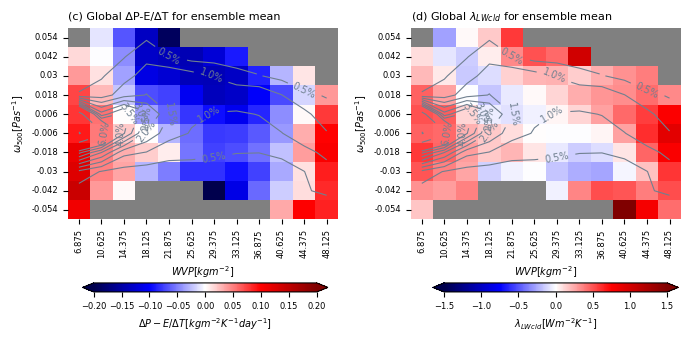

In [27]:
# LW CF
from matplotlib.colors import ListedColormap

# Pre-allocate to hold binned outputs for each ensemble
n_ens = wvp_g.shape[0]
h_dlwp_list = []
h_c_list = []

for i in range(n_ens):
    x = np.ravel(wvp_g[i, :, :])
    y = np.ravel(w500_g[i, :, :])
    z = np.ravel(dPE_p[i, :, :])
    
    h_wvp, h_omg, h_dlwp, h_c = twodbin(
        x, y, z,
        bins=[10, 12],
        n_bins=100,
        bin_range=[[-0.06, 0.06], [5, 50]]
    )
    
    h_dlwp_list.append(h_dlwp)
    h_c_list.append(h_c)

# Convert to arrays and take mean over ensembles
h_dlwp_mean = np.nanmean(np.array(h_dlwp_list), axis=0)
h_c_mean = np.nanmean(np.array(h_c_list), axis=0)

# Normalize counts to percentage
total_H_c = np.nansum(h_c_mean)
density_percentage = (h_c_mean / total_H_c) * 100

# Define contour levels
contour_levels = np.concatenate([
    np.arange(0.5, 4.5, 0.5),
    np.arange(6, np.nanmax(density_percentage) + 2, 2)
])

# Set up the figure
fig, ax = plt.subplots(1, 2, figsize=(17.8/2.54, 3))

# Create colormap
cmap = plt.cm.seismic
cmap_with_grey = ListedColormap(cmap(np.linspace(0, 1, 256)))
cmap_with_grey.set_bad(color='grey')

# Plot heatmap
sns.heatmap(
    h_dlwp_mean,
    xticklabels=np.round(h_wvp, 4),
    yticklabels=np.round(h_omg, 4),
    cmap=cmap_with_grey,
    ax=ax[0],
    vmin=-0.2, vmax=0.2,
    cbar=False
)

# Overlay contours
X, Y = np.meshgrid(np.arange(density_percentage.shape[1]), np.arange(density_percentage.shape[0]))
contour = ax[0].contour(
    X + 0.5, Y + 0.5, density_percentage,
    levels=contour_levels,
    colors='slategrey', linewidths=0.8
)
ax[0].clabel(contour, fmt="%.1f%%", inline=True, fontsize=label_fontsize)

# Labels and title
ax[0].set_xlabel('$WVP [kgm^{-2}]$', fontsize=label_fontsize)
ax[0].set_ylabel('$\omega_{500}[Pas^{-1}]$', fontsize=label_fontsize)
ax[0].set_title('(c) Global ∆P-E/∆T for ensemble mean', loc='left', fontsize=title_fontsize)
ax[0].tick_params(axis='both', labelsize=tick_fontsize)

############# second axis
n_ens = wvp_g.shape[0]
h_dlwp_list = []
h_c_list = []

for i in range(n_ens):
    x = np.ravel(wvp_g[i, :, :])
    y = np.ravel(w500_g[i, :, :])
    z = np.ravel(totdCRE_g[i, :, :])
    
    h_wvp, h_omg, h_dlwp, h_c = twodbin(
        x, y, z,
        bins=[10, 12],
        n_bins=100,
        bin_range=[[-0.06, 0.06], [5, 50]]
    )
    
    h_dlwp_list.append(h_dlwp)
    h_c_list.append(h_c)

# Convert to arrays and take mean over ensembles
h_dlwp_mean = np.nanmean(np.array(h_dlwp_list), axis=0)
h_c_mean = np.nanmean(np.array(h_c_list), axis=0)

# Normalize counts to percentage
total_H_c = np.nansum(h_c_mean)
density_percentage = (h_c_mean / total_H_c) * 100

# Define contour levels
contour_levels = np.concatenate([
    np.arange(0.5, 4.5, 0.5),
    np.arange(6, np.nanmax(density_percentage) + 2, 2)
])

# Plot heatmap
sns.heatmap(
    h_dlwp_mean,
    xticklabels=np.round(h_wvp, 4),
    yticklabels=np.round(h_omg, 4),
    cmap=cmap_with_grey,
    ax=ax[1],
    vmin=-1.5, vmax=1.5,
    cbar=False
)

# Overlay contours
X, Y = np.meshgrid(np.arange(density_percentage.shape[1]), np.arange(density_percentage.shape[0]))
contour = ax[1].contour(
    X + 0.5, Y + 0.5, density_percentage,
    levels=contour_levels,
    colors='slategrey', linewidths=0.8
)
ax[1].clabel(contour, fmt="%.1f%%", inline=True, fontsize=label_fontsize)

# Labels and title
ax[1].set_xlabel('$WVP [kgm^{-2}]$', fontsize=label_fontsize)
ax[1].set_ylabel('$\omega_{500}[Pas^{-1}]$', fontsize=label_fontsize)
ax[1].set_title('(d) Global $\lambda_{LWcld}$ for ensemble mean', loc='left', fontsize=title_fontsize)
ax[1].tick_params(axis='both', labelsize=tick_fontsize)

# Manually place colorbar for ax[0]
cax0 = fig.add_axes([0.125, 0.01, 0.35, 0.03])  # [left, bottom, width, height]
cb0 = fig.colorbar(ax[0].collections[0], cax=cax0, orientation='horizontal', extend='both')
cb0.set_label('$\Delta P-E/ \Delta T [kgm^{-2}K^{-1}day^{-1}]$', fontsize=label_fontsize)
cb0.ax.tick_params(labelsize=tick_fontsize)

# Manually place colorbar for ax[1]
cax1 = fig.add_axes([0.625, 0.01, 0.35, 0.03])
cb1 = fig.colorbar(ax[1].collections[0], cax=cax1, orientation='horizontal', extend='both')
cb1.set_label('$\lambda_{LWcld} [Wm^{-2}K^{-1}]$', fontsize=label_fontsize)
cb1.ax.tick_params(labelsize=tick_fontsize)

plt.tight_layout()
plt.savefig(fig_dir+'LWheatmap.png',
            bbox_inches='tight', facecolor='white', dpi=500)
plt.show()


/glade/derecho/scratch/geethma/tmp/ipykernel_73017/2782087992.py:25: RuntimeWarning: Mean of empty slice
  h_dlwp_mean = np.nanmean(np.array(h_dlwp_list), axis=0)
/glade/derecho/scratch/geethma/tmp/ipykernel_73017/2782087992.py:26: RuntimeWarning: Mean of empty slice
  h_c_mean = np.nanmean(np.array(h_c_list), axis=0)
/glade/derecho/scratch/geethma/tmp/ipykernel_73017/2782087992.py:93: RuntimeWarning: Mean of empty slice
  h_dlwp_mean = np.nanmean(np.array(h_dlwp_list), axis=0)
/glade/derecho/scratch/geethma/tmp/ipykernel_73017/2782087992.py:94: RuntimeWarning: Mean of empty slice
  h_c_mean = np.nanmean(np.array(h_c_list), axis=0)
/glade/derecho/scratch/geethma/tmp/ipykernel_73017/2782087992.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


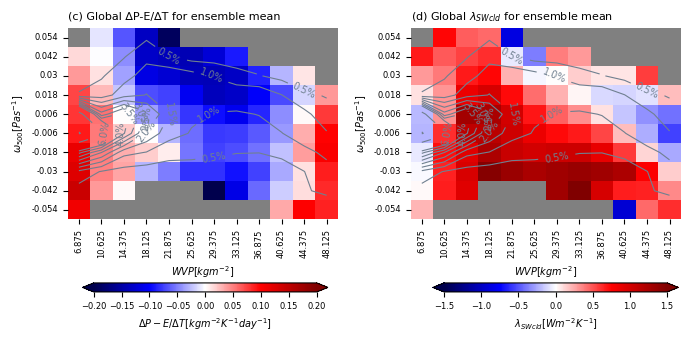

In [25]:
# SW CF
from matplotlib.colors import ListedColormap

# Pre-allocate to hold binned outputs for each ensemble
n_ens = wvp_g.shape[0]
h_dlwp_list = []
h_c_list = []

for i in range(n_ens):
    x = np.ravel(wvp_g[i, :, :])
    y = np.ravel(w500_g[i, :, :])
    z = np.ravel(dPE_p[i, :, :])
    
    h_wvp, h_omg, h_dlwp, h_c = twodbin(
        x, y, z,
        bins=[10, 12],
        n_bins=100,
        bin_range=[[-0.06, 0.06], [5, 50]]
    )
    
    h_dlwp_list.append(h_dlwp)
    h_c_list.append(h_c)

# Convert to arrays and take mean over ensembles
h_dlwp_mean = np.nanmean(np.array(h_dlwp_list), axis=0)
h_c_mean = np.nanmean(np.array(h_c_list), axis=0)

# Normalize counts to percentage
total_H_c = np.nansum(h_c_mean)
density_percentage = (h_c_mean / total_H_c) * 100

# Define contour levels
contour_levels = np.concatenate([
    np.arange(0.5, 4.5, 0.5),
    np.arange(6, np.nanmax(density_percentage) + 2, 2)
])

# Set up the figure
fig, ax = plt.subplots(1, 2, figsize=(17.8/2.54, 3))

# Create colormap
cmap = plt.cm.seismic
cmap_with_grey = ListedColormap(cmap(np.linspace(0, 1, 256)))
cmap_with_grey.set_bad(color='grey')

# Plot heatmap
sns.heatmap(
    h_dlwp_mean,
    xticklabels=np.round(h_wvp, 4),
    yticklabels=np.round(h_omg, 4),
    cmap=cmap_with_grey,
    ax=ax[0],
    vmin=-0.2, vmax=0.2,
    cbar=False
)

# Overlay contours
X, Y = np.meshgrid(np.arange(density_percentage.shape[1]), np.arange(density_percentage.shape[0]))
contour = ax[0].contour(
    X + 0.5, Y + 0.5, density_percentage,
    levels=contour_levels,
    colors='slategrey', linewidths=0.8
)
ax[0].clabel(contour, fmt="%.1f%%", inline=True, fontsize=label_fontsize)

# Labels and title
ax[0].set_xlabel('$WVP [kgm^{-2}]$', fontsize=label_fontsize)
ax[0].set_ylabel('$\omega_{500}[Pas^{-1}]$', fontsize=label_fontsize)
ax[0].set_title('(c) Global ∆P-E/∆T for ensemble mean', loc='left', fontsize=title_fontsize)
ax[0].tick_params(axis='both', labelsize=tick_fontsize)

############# second axis
n_ens = wvp_g.shape[0]
h_dlwp_list = []
h_c_list = []

for i in range(n_ens):
    x = np.ravel(wvp_g[i, :, :])
    y = np.ravel(w500_g[i, :, :])
    z = np.ravel(totdCRE_g[i, :, :])
    
    h_wvp, h_omg, h_dlwp, h_c = twodbin(
        x, y, z,
        bins=[10, 12],
        n_bins=100,
        bin_range=[[-0.06, 0.06], [5, 50]]
    )
    
    h_dlwp_list.append(h_dlwp)
    h_c_list.append(h_c)

# Convert to arrays and take mean over ensembles
h_dlwp_mean = np.nanmean(np.array(h_dlwp_list), axis=0)
h_c_mean = np.nanmean(np.array(h_c_list), axis=0)

# Normalize counts to percentage
total_H_c = np.nansum(h_c_mean)
density_percentage = (h_c_mean / total_H_c) * 100

# Define contour levels
contour_levels = np.concatenate([
    np.arange(0.5, 4.5, 0.5),
    np.arange(6, np.nanmax(density_percentage) + 2, 2)
])

# Plot heatmap
sns.heatmap(
    h_dlwp_mean,
    xticklabels=np.round(h_wvp, 4),
    yticklabels=np.round(h_omg, 4),
    cmap=cmap_with_grey,
    ax=ax[1],
    vmin=-1.5, vmax=1.5,
    cbar=False
)

# Overlay contours
X, Y = np.meshgrid(np.arange(density_percentage.shape[1]), np.arange(density_percentage.shape[0]))
contour = ax[1].contour(
    X + 0.5, Y + 0.5, density_percentage,
    levels=contour_levels,
    colors='slategrey', linewidths=0.8
)
ax[1].clabel(contour, fmt="%.1f%%", inline=True, fontsize=label_fontsize)

# Labels and title
ax[1].set_xlabel('$WVP [kgm^{-2}]$', fontsize=label_fontsize)
ax[1].set_ylabel('$\omega_{500}[Pas^{-1}]$', fontsize=label_fontsize)
ax[1].set_title('(d) Global $\lambda_{SWcld}$ for ensemble mean', loc='left', fontsize=title_fontsize)
ax[1].tick_params(axis='both', labelsize=tick_fontsize)

# Manually place colorbar for ax[0]
cax0 = fig.add_axes([0.125, 0.01, 0.35, 0.03])  # [left, bottom, width, height]
cb0 = fig.colorbar(ax[0].collections[0], cax=cax0, orientation='horizontal', extend='both')
cb0.set_label('$\Delta P-E/ \Delta T [kgm^{-2}K^{-1}day^{-1}]$', fontsize=label_fontsize)
cb0.ax.tick_params(labelsize=tick_fontsize)

# Manually place colorbar for ax[1]
cax1 = fig.add_axes([0.625, 0.01, 0.35, 0.03])
cb1 = fig.colorbar(ax[1].collections[0], cax=cax1, orientation='horizontal', extend='both')
cb1.set_label('$\lambda_{SWcld} [Wm^{-2}K^{-1}]$', fontsize=label_fontsize)
cb1.ax.tick_params(labelsize=tick_fontsize)

plt.tight_layout()
plt.savefig(fig_dir+'SWheatmap.png',
            bbox_inches='tight', facecolor='white', dpi=500)
plt.show()


/glade/derecho/scratch/geethma/tmp/ipykernel_73017/1762774174.py:25: RuntimeWarning: Mean of empty slice
  h_dlwp_mean = np.nanmean(np.array(h_dlwp_list), axis=0)
/glade/derecho/scratch/geethma/tmp/ipykernel_73017/1762774174.py:26: RuntimeWarning: Mean of empty slice
  h_c_mean = np.nanmean(np.array(h_c_list), axis=0)
/glade/derecho/scratch/geethma/tmp/ipykernel_73017/1762774174.py:93: RuntimeWarning: Mean of empty slice
  h_dlwp_mean = np.nanmean(np.array(h_dlwp_list), axis=0)
/glade/derecho/scratch/geethma/tmp/ipykernel_73017/1762774174.py:94: RuntimeWarning: Mean of empty slice
  h_c_mean = np.nanmean(np.array(h_c_list), axis=0)
/glade/derecho/scratch/geethma/tmp/ipykernel_73017/1762774174.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


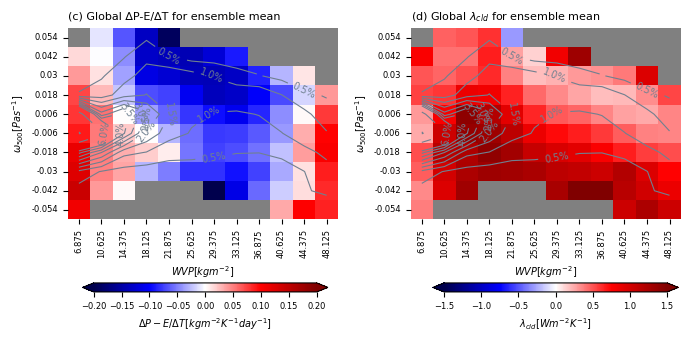

In [29]:
# total CF
from matplotlib.colors import ListedColormap

# Pre-allocate to hold binned outputs for each ensemble
n_ens = wvp_g.shape[0]
h_dlwp_list = []
h_c_list = []

for i in range(n_ens):
    x = np.ravel(wvp_g[i, :, :])
    y = np.ravel(w500_g[i, :, :])
    z = np.ravel(dPE_p[i, :, :])
    
    h_wvp, h_omg, h_dlwp, h_c = twodbin(
        x, y, z,
        bins=[10, 12],
        n_bins=100,
        bin_range=[[-0.06, 0.06], [5, 50]]
    )
    
    h_dlwp_list.append(h_dlwp)
    h_c_list.append(h_c)

# Convert to arrays and take mean over ensembles
h_dlwp_mean = np.nanmean(np.array(h_dlwp_list), axis=0)
h_c_mean = np.nanmean(np.array(h_c_list), axis=0)

# Normalize counts to percentage
total_H_c = np.nansum(h_c_mean)
density_percentage = (h_c_mean / total_H_c) * 100

# Define contour levels
contour_levels = np.concatenate([
    np.arange(0.5, 4.5, 0.5),
    np.arange(6, np.nanmax(density_percentage) + 2, 2)
])

# Set up the figure
fig, ax = plt.subplots(1, 2, figsize=(17.8/2.54, 3))

# Create colormap
cmap = plt.cm.seismic
cmap_with_grey = ListedColormap(cmap(np.linspace(0, 1, 256)))
cmap_with_grey.set_bad(color='grey')

# Plot heatmap
sns.heatmap(
    h_dlwp_mean,
    xticklabels=np.round(h_wvp, 4),
    yticklabels=np.round(h_omg, 4),
    cmap=cmap_with_grey,
    ax=ax[0],
    vmin=-0.2, vmax=0.2,
    cbar=False
)

# Overlay contours
X, Y = np.meshgrid(np.arange(density_percentage.shape[1]), np.arange(density_percentage.shape[0]))
contour = ax[0].contour(
    X + 0.5, Y + 0.5, density_percentage,
    levels=contour_levels,
    colors='slategrey', linewidths=0.8
)
ax[0].clabel(contour, fmt="%.1f%%", inline=True, fontsize=label_fontsize)

# Labels and title
ax[0].set_xlabel('$WVP [kgm^{-2}]$', fontsize=label_fontsize)
ax[0].set_ylabel('$\omega_{500}[Pas^{-1}]$', fontsize=label_fontsize)
ax[0].set_title('(c) Global ∆P-E/∆T for ensemble mean', loc='left', fontsize=title_fontsize)
ax[0].tick_params(axis='both', labelsize=tick_fontsize)

############# second axis
n_ens = wvp_g.shape[0]
h_dlwp_list = []
h_c_list = []

for i in range(n_ens):
    x = np.ravel(wvp_g[i, :, :])
    y = np.ravel(w500_g[i, :, :])
    z = np.ravel(totdCRE_g[i, :, :])
    
    h_wvp, h_omg, h_dlwp, h_c = twodbin(
        x, y, z,
        bins=[10, 12],
        n_bins=100,
        bin_range=[[-0.06, 0.06], [5, 50]]
    )
    
    h_dlwp_list.append(h_dlwp)
    h_c_list.append(h_c)

# Convert to arrays and take mean over ensembles
h_dlwp_mean = np.nanmean(np.array(h_dlwp_list), axis=0)
h_c_mean = np.nanmean(np.array(h_c_list), axis=0)

# Normalize counts to percentage
total_H_c = np.nansum(h_c_mean)
density_percentage = (h_c_mean / total_H_c) * 100

# Define contour levels
contour_levels = np.concatenate([
    np.arange(0.5, 4.5, 0.5),
    np.arange(6, np.nanmax(density_percentage) + 2, 2)
])

# Plot heatmap
sns.heatmap(
    h_dlwp_mean,
    xticklabels=np.round(h_wvp, 4),
    yticklabels=np.round(h_omg, 4),
    cmap=cmap_with_grey,
    ax=ax[1],
    vmin=-1.5, vmax=1.5,
    cbar=False
)

# Overlay contours
X, Y = np.meshgrid(np.arange(density_percentage.shape[1]), np.arange(density_percentage.shape[0]))
contour = ax[1].contour(
    X + 0.5, Y + 0.5, density_percentage,
    levels=contour_levels,
    colors='slategrey', linewidths=0.8
)
ax[1].clabel(contour, fmt="%.1f%%", inline=True, fontsize=label_fontsize)

# Labels and title
ax[1].set_xlabel('$WVP [kgm^{-2}]$', fontsize=label_fontsize)
ax[1].set_ylabel('$\omega_{500}[Pas^{-1}]$', fontsize=label_fontsize)
ax[1].set_title('(d) Global $\lambda_{cld}$ for ensemble mean', loc='left', fontsize=title_fontsize)
ax[1].tick_params(axis='both', labelsize=tick_fontsize)

# Manually place colorbar for ax[0]
cax0 = fig.add_axes([0.125, 0.01, 0.35, 0.03])  # [left, bottom, width, height]
cb0 = fig.colorbar(ax[0].collections[0], cax=cax0, orientation='horizontal', extend='both')
cb0.set_label('$\Delta P-E/ \Delta T [kgm^{-2}K^{-1}day^{-1}]$', fontsize=label_fontsize)
cb0.ax.tick_params(labelsize=tick_fontsize)

# Manually place colorbar for ax[1]
cax1 = fig.add_axes([0.625, 0.01, 0.35, 0.03])
cb1 = fig.colorbar(ax[1].collections[0], cax=cax1, orientation='horizontal', extend='both')
cb1.set_label('$\lambda_{cld} [Wm^{-2}K^{-1}]$', fontsize=label_fontsize)
cb1.ax.tick_params(labelsize=tick_fontsize)

plt.tight_layout()
plt.savefig(fig_dir+'heatmap.png',
            bbox_inches='tight', facecolor='white', dpi=500)
plt.show()


# Figure - Ensemble-mean WVP (shading) and ω500 (contours)

In [16]:
pr_cmap = (LinearSegmentedColormap.from_list('pr_cmap', themes.palettes.Sequential.purples)).reversed()

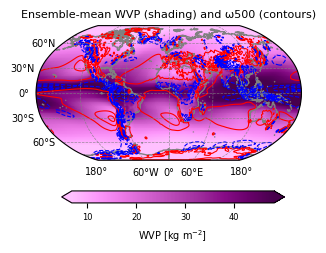

In [17]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Compute ensemble mean fields
wvp_mean = np.nanmean(wvp_g, axis=0)
w500_mean = np.nanmean(w500_g, axis=0)

# Set up projection and figure
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, figsize=(8.7/2.54, 4))

# Plot WVP as shaded color
cmap = pr_cmap #plt.cm.YlGnBu
lon = wvp_g.lon
lat = wvp_g.lat
wvp_plot = ax.pcolormesh(lon, lat, wvp_mean, transform=ccrs.PlateCarree(), cmap=cmap, vmin=h_wvp.min(), vmax=h_wvp.max())

# colorbar
cax1 = fig.add_axes([0.2, 0.22, 0.65, 0.03])
cb1 = fig.colorbar(ax.collections[0], cax=cax1, orientation='horizontal', extend='both')
cb1.set_label('WVP [kg m$^{-2}$]', fontsize=label_fontsize)
cb1.ax.tick_params(labelsize=tick_fontsize)

# map features
ax.add_feature(cfeature.LAND, facecolor='#9D722A')
coastline_feature = cfeature.GSHHSFeature(scale='auto', edgecolor='grey')
ax.add_feature(coastline_feature)
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='grey', alpha=0.8, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'fontsize': label_fontsize}
gl.ylabel_style = {'fontsize': label_fontsize}

# Overlay ω500 contours
w500_min = np.nanmin(w500_mean)
w500_min_r = np.floor(w500_min * 100) / 100
w500_max = np.nanmax(w500_mean)
w500_max_r = np.ceil(w500_max * 100) / 100
contours = ax.contour(lon, lat, w500_mean, transform=ccrs.PlateCarree(),
                      levels=np.arange(0.01, w500_max_r, 0.03), colors='red', linewidths=0.8)
contours = ax.contour(lon, lat, w500_mean, transform=ccrs.PlateCarree(),
                      levels=np.arange(w500_min_r, -0.005, 0.02), colors='blue', linewidths=0.8)

ax.set_title('Ensemble-mean WVP (shading) and ω500 (contours)', fontsize=title_fontsize)
# plt.tight_layout()
plt.savefig('final_figures/wvp_omega_map.png', bbox_inches='tight', dpi=500, facecolor='white')
plt.show()


# updated figure - global mean P/LWP with ∆LWP/∆T and λcld

In [18]:
dVAR_map_o = [dLWP_g.data, totdCRE_g.data]
dVAR_map_o = np.array(dVAR_map_o)
dVar_name = ['∆LWP/∆T', 'λ$_{cld}$']

grad = [PE_g_mean.data]
grad = np.array(grad)
grad_name = ['P/LWP']

/glade/u/home/geethma/.conda/envs/wgh/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


<Figure size 449x280 with 0 Axes>

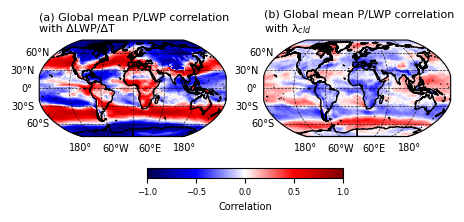

In [19]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import scipy.stats as stats

# Set figure width to 11.4 cm = 4.49 inches for PNAS single-column
fig = plt.figure(figsize=(4.49, 2.8))  # Adjusted height to maintain horizontal layout

lat_sh = dLWP_g.lat.shape[0]
lon_sh = dLWP_g.lon.shape[0]

nums = [[0, 0], [0, 1]]
title_num = ['(a) ', '(b) ']

# PNAS-compliant font sizes
title_fontsize = 8
label_fontsize = 7
tick_fontsize = 6

# Create 1 row, 2 columns
fig, axs = plt.subplots(1, 2, figsize=(4.49, 2.8), subplot_kw={'projection': ccrs.Robinson()}, constrained_layout=True)

for ax_n, ax in enumerate(axs.flat):
    g = nums[ax_n][0]
    d = nums[ax_n][1]

    correlation = np.full((lat_sh, lon_sh), np.nan)
    for i in range(lat_sh):
        for j in range(lon_sh):
            correlation[i, j] = stats.spearmanr(grad[g], dVAR_map_o[d, :, i, j], nan_policy='omit')[0]

    cbar_img = ax.pcolormesh(dLWP_g.lon, dLWP_g.lat, correlation,
                             transform=ccrs.PlateCarree(), cmap='seismic',
                             vmin=-1, vmax=1)

    ax.add_feature(cfeature.LAND, facecolor='white')
    ax.add_feature(cfeature.GSHHSFeature(scale='auto', edgecolor='black'))
    ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
    ax.set_title(title_num[ax_n] + 'Global mean ' + grad_name[g] + ' correlation\nwith ' + dVar_name[d],
                 fontsize=title_fontsize, loc='left')
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='black', alpha=0.8, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'fontsize': label_fontsize}  # optional: set label font size
    gl.ylabel_style = {'fontsize': label_fontsize}

# Single horizontal colorbar below
cbar = fig.colorbar(cbar_img, ax=axs, orientation='horizontal', fraction=0.05, pad=0.07)
cbar.set_label('Correlation', fontsize=label_fontsize)
cbar.ax.tick_params(labelsize=tick_fontsize)

plt.savefig(fig_dir+'gPE_SW∆CRE_∆LWP_correlation.png',
            bbox_inches='tight', facecolor='white', dpi=600)
plt.show()


# updated Figure - ∂LWP/∂P_EC with ∆LWP/∆T and λcld

/glade/u/home/geethma/.conda/envs/wgh/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


<Figure size 449x280 with 0 Axes>

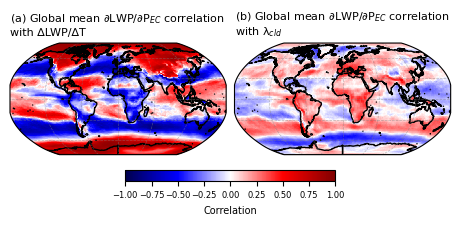

In [20]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import scipy.stats as stats


dVar_name = ['∆LWP/∆T', 'λ$_{cld}$']


# Set figure width to 11.4 cm = 4.49 inches for PNAS single-column
fig = plt.figure(figsize=(4.49, 2.8))  # Adjusted height to maintain horizontal layout

lat_sh = dLWP_g.lat.shape[0]
lon_sh = dLWP_g.lon.shape[0]

nums = [[0, 0], [0, 1]]
title_num = ['(a) ', '(b) ']

grad = [PPE_grad_LWP_PRC.data]
grad = np.array(grad)
grad_name = ['∂LWP/∂P$_{EC}$']

# Create 1 row, 2 columns
fig, axs = plt.subplots(1, 2, figsize=(4.49, 2.8), subplot_kw={'projection': ccrs.Robinson()}, constrained_layout=True)

for ax_n, ax in enumerate(axs.flat):
    g = nums[ax_n][0]
    d = nums[ax_n][1]

    correlation = np.full((lat_sh, lon_sh), np.nan)
    for i in range(lat_sh):
        for j in range(lon_sh):
            correlation[i, j] = stats.spearmanr(grad[g], dVAR_map_o[d, :, i, j], nan_policy='omit')[0]

    cbar_img = ax.pcolormesh(dLWP_g.lon, dLWP_g.lat, correlation,
                             transform=ccrs.PlateCarree(), cmap='seismic',
                             vmin=-1, vmax=1)

    ax.add_feature(cfeature.LAND, facecolor='white')
    ax.add_feature(cfeature.GSHHSFeature(scale='auto', edgecolor='black'))
    ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
    ax.set_title(title_num[ax_n] + 'Global mean ' + grad_name[g] + ' correlation\nwith ' + dVar_name[d],
                 fontsize=title_fontsize, loc='left')

    gl = ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Single horizontal colorbar below
cbar = fig.colorbar(cbar_img, ax=axs, orientation='horizontal', fraction=0.05, pad=0.07)
cbar.set_label('Correlation', fontsize=label_fontsize)
cbar.ax.tick_params(labelsize=tick_fontsize)

plt.savefig(fig_dir+'∂LWP∂P_SW∆CRE_∆LWP_correlation.png',
            bbox_inches='tight', facecolor='white', dpi=600)
plt.show()


# figure - precipitation efficiency from a single member

In [5]:
var_list = ['Pmap_ol_l', 'Pmap_ol_c', 'LWPmap_ol']
var_dict = {var: load_xarray(var) for var in var_list}

Pmap_ol = var_dict['Pmap_ol_l'] + var_dict['Pmap_ol_c']   #unit:[m/s]
PE_g = Pmap_ol*1000/var_dict['LWPmap_ol']  #unit: [ms-1]*[kgm-3]/[kgm-2] = [s-1]


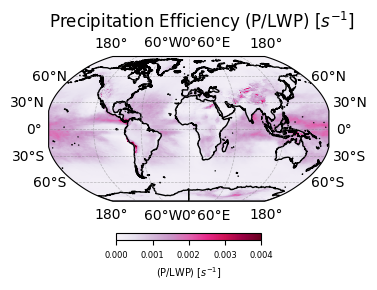

In [11]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
fig, axs = plt.subplots(1, 1, figsize=(4.49, 2.8), subplot_kw={'projection': ccrs.Robinson()}, constrained_layout=True)

# PE_g[0].plot(cmap='PuRd')
ax = axs
cbar_img = ax.pcolormesh(PE_g.lon, PE_g.lat, PE_g[0],
                         transform=ccrs.PlateCarree(), cmap='PuRd',
                         vmin=0, vmax=0.004)

ax.add_feature(cfeature.LAND, facecolor='white')
ax.add_feature(cfeature.GSHHSFeature(scale='auto', edgecolor='black'))
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.set_title('Precipitation Efficiency (P/LWP) $[s^{-1}]$', loc='left')

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Single horizontal colorbar below
cbar = fig.colorbar(cbar_img, ax=axs, orientation='horizontal', fraction=0.05, pad=0.07)
cbar.set_label('(P/LWP) $[s^{-1}]$', fontsize=label_fontsize)
cbar.ax.tick_params(labelsize=tick_fontsize)

plt.savefig('final_figures/precip_eff_spatial_map.png',
            bbox_inches='tight', facecolor='white', dpi=600)
plt.show()

# figure 3

In [12]:
var_list = ['Pmap_ol_l', 'Pmap_ol_c', 'dLWCREmap', 'dSWCREmap', 'dTSmap_gol', 'LWPmap_ol', 'dLWPmap_gol']
var_dict = {var: load_xarray(var) for var in var_list}

Pmap_ol = var_dict['Pmap_ol_l'] + var_dict['Pmap_ol_c']
PE_g = Pmap_ol/var_dict['LWPmap_ol']
totdCRE_g = (var_dict['dLWCREmap']+var_dict['dSWCREmap'])/var_dict['dTSmap_gol']

_, PPE_grad_LWP_PRC = cyclone_metrics()

common_members = np.intersect1d(PE_g['runs'], totdCRE_g['runs'])
common_members = np.intersect1d(common_members, PPE_grad_LWP_PRC['runs'])
totdCRE_g = totdCRE_g.sel(runs=common_members)
PE_g = PE_g.sel(runs=common_members)
dLWPmap_gol = var_dict['dLWPmap_gol']
dLWPmap_gol = dLWPmap_gol.sel(runs=common_members)
# PPE_grad_LWP_WCB = PPE_grad_LWP_WCB.sel(runs=common_members)
PPE_grad_LWP_PRC = PPE_grad_LWP_PRC.sel(runs=common_members)

PE_g_mean,_,_ = lat_weight_mean(PE_g)

dVAR_map_o = [PE_g_mean.data, PPE_grad_LWP_PRC.data]
dVAR_map_o = np.array(dVAR_map_o)
dVar_name = ['global mean P/LWP', '∂LWP/∂P$_{EC}$']

grad = [PE_g.data]
grad = np.array(grad)
grad_name = ['P/LWP']

In [13]:
from scipy.stats import spearmanr
file = np.load('/glade/campaign/uwyo/wyom0124/variables_filtered/pe.npz')
pe_gm_o = xr.DataArray(file['data'], dims=['runs'], coords={'runs':file['runs']})  # [s-1]
pe_gm_o = pe_gm_o.sel(runs=common_members)
corr, p_value = spearmanr(PPE_grad_LWP_PRC.data*86400, pe_gm_o.data)
print(corr, p_value)

-0.9701408371384408 1.9786941441586365e-156


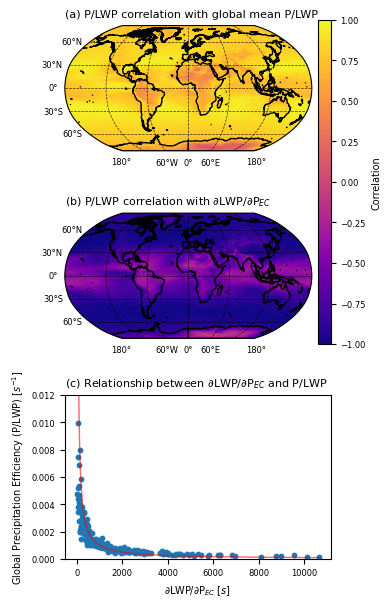

In [16]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import scipy.stats as stats

# Set figure width to 8.7 cm (3.43 inches) — PNAS single-column width
fig = plt.figure(figsize=(3.43, 7))  # Adjust height as needed

# GridSpec: 3 rows, 2 columns (right column reserved for shared colorbar on top row)
gs = gridspec.GridSpec(3, 2, width_ratios=[20, 1], height_ratios=[1, 1, 1.2], hspace=0.35, wspace=0.05)

lat_sh = dLWPmap_gol.lat.shape[0]
lon_sh = dLWPmap_gol.lon.shape[0]
nums = [[0,0], [0,1]]
title_num = ['(a) ', '(b) ']

# --- Top two maps ---
for ax_n in range(2):
    ax = fig.add_subplot(gs[ax_n, 0], projection=ccrs.Robinson())
    g = nums[ax_n][0]
    d = nums[ax_n][1]
    
    correlation = np.full((lat_sh, lon_sh), np.nan)
    for i in range(lat_sh):
        for j in range(lon_sh):
            correlation[i, j] = stats.spearmanr(grad[g, :, i, j], dVAR_map_o[d], nan_policy='omit')[0]

    img = ax.pcolormesh(dLWPmap_gol.lon, dLWPmap_gol.lat, correlation,
                        transform=ccrs.PlateCarree(), cmap='plasma',
                        vmin=-1, vmax=1)
    ax.add_feature(cfeature.LAND, facecolor='white')
    ax.add_feature(cfeature.GSHHSFeature(scale='auto', edgecolor='black'))
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='black', alpha=0.8, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'fontsize': 6}  # optional: set label font size
    gl.ylabel_style = {'fontsize': 6}
    ax.set_title(title_num[ax_n] + grad_name[g] + ' correlation with ' + dVar_name[d],
                 fontsize=title_fontsize, loc='left')

# --- Shared vertical colorbar for the two maps ---
cbar_ax = fig.add_subplot(gs[0:2, 1])  # Span both top rows in the second column
cbar = plt.colorbar(img, cax=cbar_ax, orientation='vertical')
cbar.set_label('Correlation', fontsize=label_fontsize)
cbar.ax.tick_params(labelsize=tick_fontsize)

# --- Scatter plot (bottom row, full width) ---
ax_scatter = fig.add_subplot(gs[2, :])  # Bottom row, span both columns
ax_scatter.scatter(PPE_grad_LWP_PRC.data * 86400, pe_gm_o.data, s=10)
x_values = np.sort(PPE_grad_LWP_PRC.data * 86400)
y_values = 1 / x_values
ax_scatter.plot(x_values, y_values, 'r', alpha=0.6, linewidth=1)

ax_scatter.set_ylim(0, 0.012)
ax_scatter.set_xlabel('∂LWP/∂P$_{EC}$ [$s$]', fontsize=label_fontsize)
ax_scatter.set_ylabel('Global Precipitation Efficiency (P/LWP) [$s^{-1}$]', fontsize=label_fontsize)
ax_scatter.set_title('(c) Relationship between ∂LWP/∂P$_{EC}$ and P/LWP', loc='left', fontsize=title_fontsize)
ax_scatter.tick_params(axis='both', labelsize=tick_fontsize)

# Save figure
plt.savefig('final_figures/PE_correlation.png',
            bbox_inches='tight', dpi=600, facecolor='white')
plt.show()


# updated constrain figure

## Load

In [21]:
convert = 0.84  # multiply by 0.84 to consistent with abrupt4xco2 (Fig 1e in Qin et al 2022)

In [22]:
ocean=False
Lv = 2264705.  # J/kg

### ∆LWP map
dLWP_TSmap = dLWP_g.copy()  #datasets['dLWPmap'] / datasets['dTSmap']  # kgm-2K-1
dLWP_TSmap = dLWP_TSmap.assign_coords(lon=(((dLWP_TSmap.lon + 180) % 360) - 180))
dLWP_TSmap = dLWP_TSmap.sortby('lon')

### cloud feedback
cf = totdCRE_g.copy()
cf = cf*convert   # multiply by convert value to consistent with abrupt4xco2 (Fig 1e in Qin et al 2022)
cf = cf.assign_coords(lon=(((cf.lon + 180) % 360) - 180))
cf = cf.sortby('lon')

### PD MC map
PDMC_QFLX_da = pe_maps_ol.copy()

### converging area
convergence_mask = PDMC_QFLX_da.where(PDMC_QFLX_da > 0, other=np.nan)
# convergence_mask = PDMC_QFLX_da

### incoming solar flux  #downwelling SW flux at TOA
SW_d_list = []
run_numbers = []
for fnum in range(263):
    try:
        fnums = f"{fnum:03d}"
        SWfn_list = np.load(f'/glade/derecho/scratch/geethma/PPE_PD_inSolar/maps_{fnums}.npz')  #PPE_PD_FSDTOA
        SW_maps = np.mean(SWfn_list['data'], axis=0)
        # SW_mean = lat_weight_mean(SW_maps)
        SW_d_list.append(SW_maps)
        run_numbers.append(fnum)
    except FileNotFoundError:
        print(f'{fnums} not available.')
        continue
SW_d_list = np.array(SW_d_list)
SWD_da = xr.DataArray(data=SW_d_list,
                      coords={'runs': run_numbers,
                              'lat': SWfn_list['lat'],
                              'lon': SWfn_list['lon']},
                      dims=['runs','lat','lon'])
SWD_da = SWD_da.assign_coords(lon=(((SWD_da.lon + 180) % 360) - 180))
SWD_da = SWD_da.sortby('lon')  # [Wm-2]
if ocean:
    from get_land_mask import get_land_mask
    land_mask = get_land_mask(SWD_da['lat'], SWD_da['lon'])[0]
    land_mask_da = xr.DataArray(
        land_mask,
        coords={'lat': SWD_da.lat, 'lon': SWD_da.lon},
        dims=['lat', 'lon']
    )
    SWD_da = SWD_da * land_mask_da



In [23]:
def sel_regime(xarray, lat_min, lat_max):
    north = xarray.sel(lat=slice(lat_min, lat_max))
    south = xarray.sel(lat=slice(-lat_max, -lat_min))
    xarray_sel = xr.concat([south, north], dim='lat')

    return xarray_sel


In [9]:
# cloudlwp = obs_dict['cloudlwp']*0.001  #[kg/m2]
# wcb = obs_dict['sfcwind']*obs_dict['wvp']*2.66e-7*86400  #[m/s * kg/m2 * m.mm/kg * s/day = mm/day]
# num_bins = 10
# ind = ~np.isnan(wcb * cloudlwp)

# # Calculate bins and statistics in one go
# bin_stats = stats.binned_statistic(wcb[ind], [cloudlwp[ind], wcb[ind]], statistic='mean', bins=num_bins)
# lwp_bin, wcb_bin = bin_stats.statistic
# count = stats.binned_statistic(wcb[ind], wcb[ind], statistic='count', bins=num_bins).statistic
# obs_grad = np.nansum(np.gradient(lwp_bin)/np.gradient(wcb_bin)*count)/np.nansum(count)

# obs_grad_LWP_WCB = obs_grad.copy()

# lower_bound_WCB = obs_grad_LWP_WCB - 0.1 * obs_grad_LWP_WCB
# upper_bound_WCB = obs_grad_LWP_WCB + 0.1 * obs_grad_LWP_WCB

In [24]:
cloudlwp = obs_dict['cloudlwp']*0.001  #[kg/m2]
prc = obs_dict['MWprecipitation']*24  #[mm/day]
num_bins = 10
ind = np.isnan(prc*cloudlwp)==False

### take weighted bins
lwp_bin = stats.binned_statistic(prc[ind], cloudlwp[ind], statistic='mean', bins=num_bins)[0]
prc_bin = stats.binned_statistic(prc[ind], prc[ind], statistic='mean', bins=num_bins)[0]
count   = stats.binned_statistic(prc[ind], prc[ind], statistic='count', bins=num_bins)[0]
obs_grad = np.nansum(np.gradient(lwp_bin)/np.gradient(prc_bin)*count)/np.nansum(count)

print(obs_grad)

obs_grad_LWP_PRC = obs_grad

lower_bound_PRC = obs_grad_LWP_PRC - 0.35 * obs_grad_LWP_PRC
upper_bound_PRC = obs_grad_LWP_PRC + 0.35 * obs_grad_LWP_PRC

0.008106015839806293


In [25]:
pe_metric = PPE_grad_LWP_PRC #PPE_grad_LWP_WCB
obs_pe_metric = obs_grad_LWP_PRC #obs_grad_LWP_WCB
lower_pe_metric, upper_pe_metric = lower_bound_PRC, upper_bound_PRC  #lower_bound_WCB, upper_bound_WCB
xtitle = '$∂LWP/∂P_{EC}$' #'$∂LWP/∂WCB_{EC}$'

In [26]:
#### MERRA2 constraint by area of convergence * SWD
## Moisture convergence
merrafn = xr.open_mfdataset('/glade/derecho/scratch/geethma/merra2/EFLUX/*.nc4', 
                            combine='by_coords', parallel=True)
monthly_merrafn = merrafn.mean(dim='time')
merraMC = (monthly_merrafn['PRECTOT'] - monthly_merrafn['EFLUX']/Lv)*86400
# plt.figure(); merraMC.plot(cmap='seismic')

### TOA SW downwelling
merrafn = xr.open_mfdataset('/glade/derecho/scratch/geethma/merra2/in_solar/*.nc4', 
                            combine='by_coords', parallel=True)  # SW_TOA
monthly_merrafn = merrafn.mean(dim='time')
merraSW = monthly_merrafn['SWTDN']
if ocean:
    from get_land_mask import get_land_mask
    land_mask = get_land_mask(merraMC['lat'], merraMC['lon'])[0]
    merraMC *= land_mask
    merraSW *= land_mask
# plt.figure(); merraSW.plot(cmap='seismic')

# Observational constraint on convergence area
merra_conv_area = merraMC.where(merraMC > 0, other=np.nan)
merra_conv_sw = merra_conv_area*merraSW

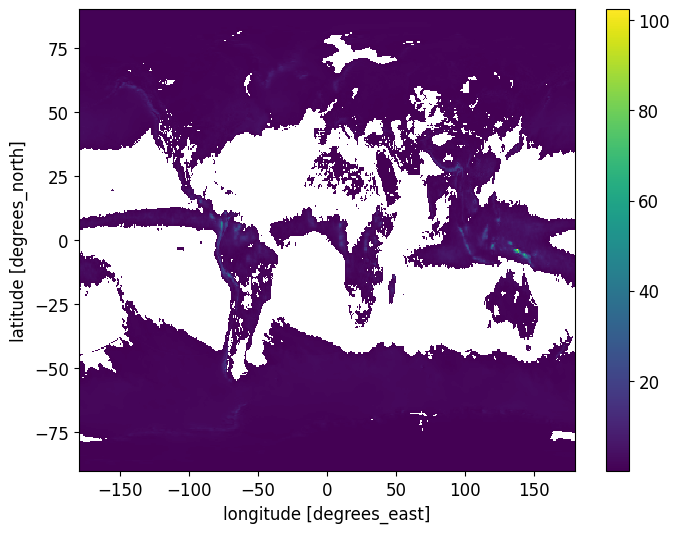

In [22]:
merra_conv_area.plot()

In [27]:
default, default_sem, _ = lat_weight_mean(sel_regime(cf,0,90))

In [33]:
np.array(default.sel(runs=0))

array(0.47222112)

In [14]:
# def plot_pdfs(data, bin_c):
#     conf = 2.5
#     a = data
#     a_min = np.percentile(a,conf)
#     a_med = np.percentile(a,50)
#     a_max = np.percentile(a,100.-conf)
#     # print('the original range is: ',a_min,a_max)
#     print('95th percentile taken')
#     a = np.array(a)
#     a_95 = a[(a >= a_min) & (a <= a_max)]

#     hist, bins = np.histogram(a_95, bins=bin_c, density=True)
#     bin_centers = (bins[1:]+bins[:-1])*0.5

#     return bin_centers, hist

In [34]:
def plot_pdfs_diff(data, bin_c):
    conf = 2.5
    a = data
    a_min = np.percentile(a,conf)
    a_med = np.percentile(a,50)
    a_max = np.percentile(a,100.-conf)
    # print('the original range is: ',a_min,a_max)
    print('95th percentile taken')
    a = np.array(a)
    a_95 = a[(a >= a_min) & (a <= a_max)]

    hist, bins = np.histogram(a_95, bins=bin_c, density=True)
    bin_centers = (bins[1:]+bins[:-1])*0.5

    return bin_centers, hist*np.diff(bins)

## RF data saved

In [53]:
# GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.mixture import GaussianMixture  
import numpy as np

def emulate_regimes(x_p, y_p1, y_p2, y_p3, c_p):
    # Determine valid (non-NaN) points
    ind = ~np.isnan(x_p * y_p1 * y_p2 * y_p3 * c_p)
    
    # Stack predictors
    input = np.column_stack((
        x_p.data[ind], 
        y_p1.data[ind], 
        y_p2.data[ind], 
        y_p3.data[ind]
    ))
    output = c_p[ind]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        input, output, test_size=0.2, random_state=42
    )

    # Define parameter grid
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 3, 5],
        'bootstrap': [True, False]
    }

    # Initialize RF Regressor
    rf = RandomForestRegressor(random_state=13)

    # GridSearchCV setup
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=3,                  # 3-fold cross-validation
        scoring='r2',          # R² score
        verbose=2,
        n_jobs=-1              # Use all processors
    )

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)

    # Best model
    best_rf = grid_search.best_estimator_
    print("Best Hyperparameters:", grid_search.best_params_)

    # Predict on training set with best RF
    Ptrain = best_rf.predict(X_train)

    # Metrics
    r2 = r2_score(y_train, Ptrain)
    mse = mean_squared_error(y_train, Ptrain)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_train, Ptrain)
    
    print("Training Performance with Best RF:")
    print("R² Score:", r2)  
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("MAE:", mae)

    # GMM sampling
    n_samples = 1_000_000
    gmm = GaussianMixture(n_components=3, random_state=0)
    gmm.fit(X_train)

    X_new, _ = gmm.sample(n_samples)
    P_new = best_rf.predict(X_new)

    return X_new, P_new


In [73]:
lat_ranges = [(0,20, 'tropics'), (20, 50, 'subtropics'), (50, 90, 'extratropics')]

PPE_prior = []
RF_prior = []
RF_posterior = []
constrain_arr = []
MC_constrained = []

for idx, (min_lat, max_lat, regime) in enumerate(lat_ranges):
    dLWP_TSmap_sel = sel_regime(dLWP_TSmap,min_lat,max_lat)
    convergence_mask_sel = sel_regime(convergence_mask,min_lat,max_lat)
    SWD_da_sel = sel_regime(SWD_da,min_lat,max_lat)
    cf_sel = sel_regime(cf,min_lat,max_lat)

    dLWP_TSmap_sel_mean = lat_weight_mean(dLWP_TSmap_sel)[0]
    convergence_mask_sel_mean = lat_weight_mean(convergence_mask_sel)[0]
    SWD_da_sel_mean = lat_weight_mean(SWD_da_sel)[0]
    cf_mean, cf_sem, cf_std = lat_weight_mean(cf_sel)
    conv_filter = convergence_mask_sel*SWD_da_sel
    filter_conv = lat_weight_mean(conv_filter)[0]

    final_data_n = {
        "xmap": pe_metric,
        "ymap1": dLWP_TSmap_sel_mean,
        "ymap2": convergence_mask_sel_mean,
        "ymap3": SWD_da_sel_mean,
        "clrmap": cf_mean,
        "filter": filtered_TOA_15,
        "filter2": filter_conv,
    }
    keys = list(final_data_n.keys())
    common_members = final_data_n[keys[0]]['runs'].values
    for name in keys:
        common_members = np.intersect1d(common_members, final_data_n[name]['runs'].values)
    final_data = {name: ds.sel(runs=common_members) for name, ds in final_data_n.items()}

    sel_merra_conv_sw = sel_regime(merra_conv_sw, min_lat, max_lat)
    merraMC_mean, merraMC_sem, _ = lat_weight_mean(sel_merra_conv_sw)
    from scipy.stats import norm
    z_95 = norm.ppf(0.975)
    obs_constraint_lower = merraMC_mean.values - z_95 * merraMC_sem.values
    obs_constraint_upper = merraMC_mean.values + z_95 * merraMC_sem.values

    print(merraMC_mean.values, obs_constraint_lower, obs_constraint_upper)

    PPE_conv_SWD = final_data['filter2']
    constrained = (PPE_conv_SWD.values >= obs_constraint_lower) & (PPE_conv_SWD.values <= obs_constraint_upper)

    x_p = final_data['xmap']
    y_p1 = final_data['ymap1']
    y_p2 = final_data['ymap2']
    y_p3 = final_data['ymap3']
    y_p = y_p1*y_p2*y_p3
    c_p = final_data['clrmap']
    X_new, P_new = emulate_regimes(x_p, y_p1, y_p2, y_p3, c_p.values)

    pe_constrained = (X_new[:,0] >= lower_pe_metric) & (X_new[:,0] <= upper_pe_metric)
    conv_constrained = (X_new[:,2]*X_new[:,3] >= obs_constraint_lower) & (X_new[:,2]*X_new[:,3] <= obs_constraint_upper)
    both_constrained = pe_constrained & conv_constrained
    P_new_constrained = P_new[both_constrained]

    PPE_prior.append([x_p.data, y_p.data, c_p.data])
    RF_prior.append([X_new[:,0], X_new[:,1]*X_new[:,2]*X_new[:,3], P_new])
    RF_posterior.append(P_new_constrained)
    constrain_arr.append(constrained)
    MC_constrained.append(conv_constrained)

np.savez(fig_dir+'updated_RF_results.npz', PPE_prior=PPE_prior, RF_prior=RF_prior, RF_posterior=RF_posterior, runs=x_p.runs, constrain_arr=constrain_arr, MC_constrained=MC_constrained)


1082.0025788794226 992.9501967281166 1171.0549610307285
Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=1, min_samples

/glade/u/home/geethma/.local/lib/python3.9/site-packages/numpy/lib/npyio.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


## use saved RF data

In [74]:
data = np.load(fig_dir+'updated_RF_results.npz', allow_pickle=True)
PPE_prior = data['PPE_prior']
RF_prior = data['RF_prior']
RF_posterior = data['RF_posterior']
runs = data['runs']
constrain_arr = data['constrain_arr']
MC_constrained = data['MC_constrained']

In [75]:
# inputs
F_sub_members = np.array(RF_posterior[1])  
F_ext_members = np.array(RF_posterior[2])  

# weights (must sum to 1)
lat_bounds = [(0,20), (20, 50), (50, 90)]
weights = [np.sin(np.radians(max_lat)) - np.sin(np.radians(min_lat)) for min_lat, max_lat in lat_bounds]
weights = np.array(weights) / np.sum(weights)
w_sub, w_ext, w_trop = weights[1], weights[2], weights[0]


B = 1000
M = len(F_sub_members)
m_idx = np.random.randint(0, M, size=B)  # bootstrap members with replacement
sub_draws = F_sub_members[m_idx]
M = len(F_ext_members)
m_idx = np.random.randint(0, M, size=B)  # bootstrap members with replacement
ext_draws = F_ext_members[m_idx]
tr_prior = RF_prior[0][2]
M = len(tr_prior)
m_idx = np.random.randint(0, M, size=B)  # bootstrap members with replacement
trop_draws = tr_prior[m_idx]

Fglob = w_sub*sub_draws + w_ext*ext_draws + w_trop*trop_draws
mean = Fglob.mean()
lo, hi = np.percentile(Fglob, [2.5, 97.5])
mean, lo, hi


(0.6630856827792916, 0.5553923501618071, 0.7830838685245014)

In [76]:
import matplotlib.gridspec as gridspec
import scipy.stats as stats

prior_means = [np.nanmean(i) for i in RF_prior]
prior_stds  = [np.nanstd(i)  for i in RF_prior]
post_means  = [np.nanmean(i) for i in RF_posterior]
post_stds   = [np.nanstd(i)  for i in RF_posterior]

# lat_bounds = [(20, 50), (50, 90)]
# weights = [np.sin(np.radians(max_lat)) - np.sin(np.radians(min_lat)) for min_lat, max_lat in lat_bounds]
# weights = np.array(weights) / np.sum(weights)

n_samples_global = 100000

prior_samples = []
for i in range(len(prior_means)):
    samples = np.random.normal(prior_means[i], prior_stds[i], int(weights[i] * n_samples_global))
    prior_samples.append(samples)
global_prior_samples = np.concatenate(prior_samples)

post_samples = []
for i in range(len(prior_means)):
    samples = np.random.normal(post_means[i], post_stds[i], int(weights[i] * n_samples_global))
    post_samples.append(samples)
global_post_samples = np.concatenate(post_samples)

In [77]:
# function to calculate the standard deviation of the total SW FB component  
def combine_independent(means, stds):
    means = np.array(means, float)
    stds = np.array(stds, float)
    mu_total = means.sum()
    sigma_total = np.sqrt((stds**2).sum())
    return mu_total, sigma_total

95th percentile taken
1.37013944774018 -0.8356149280417462
95th percentile taken
0.8987092139181725 0.37982384625738796


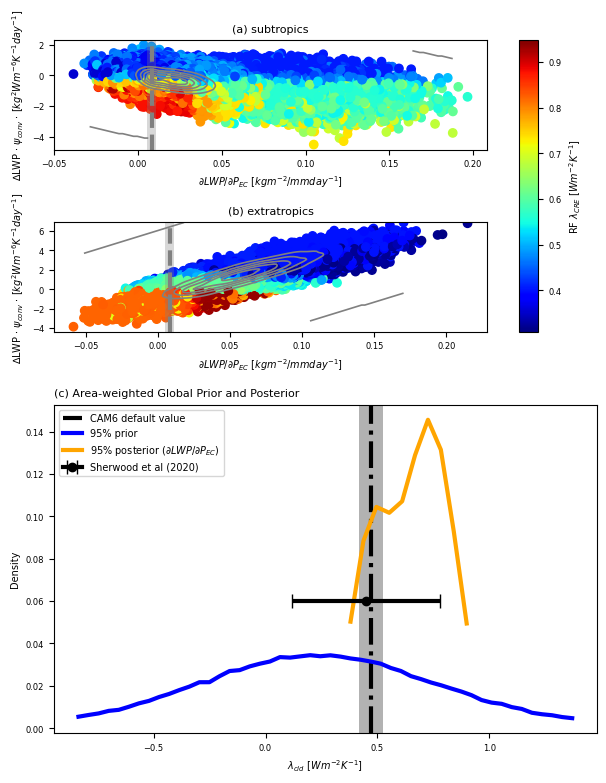

In [80]:
lat_ranges = [(20, 50, 'subtropics'), (50, 90, 'extratropics')]
regimes = ['subtropics', 'extratropics']
# Set figure width to 11.4 or 17.8 cm  — PNAS width
fig = plt.figure(figsize=(17.8/2.54, 9))  # Adjust height as needed
title_num = ['(a) ', '(b) ', '(c) ']
# GridSpec: 3 rows, 4 columns (right 3 columns reserved for shared colorbar on top row)
gs = gridspec.GridSpec(3, 3, width_ratios=[18, 0.8, 1.1], height_ratios=[1, 1, 3], hspace=0.4, wspace=0.2)

nums = [[0,0], [0,1]]

# --- Top two maps ---
for ax_n in range(2):
    ax = fig.add_subplot(gs[ax_n, 0])
    g = nums[ax_n][0]
    d = nums[ax_n][1]
    regime = regimes[ax_n]

    temp = RF_prior[ax_n+1]
    img = ax.scatter(temp[0], temp[1], c=temp[2], 
                     cmap='jet')
    p_temp = PPE_prior[ax_n+1]
    x_p = xr.DataArray(p_temp[0], dims=['runs'], coords={'runs': runs})
    y_p = xr.DataArray(p_temp[1], dims=['runs'], coords={'runs': runs})
    c_p = xr.DataArray(p_temp[2], dims=['runs'], coords={'runs': runs})

    # p_img = ax.scatter(x_p, y_p, c=c_p, 
    #                     cmap='spring', marker='s', s=72, vmin=-0.6, vmax=0.6)
    # constrained = constrain_arr[ax_n+1]
    conv_constrained = MC_constrained[ax_n+1]
    # ax.scatter(temp[0][conv_constrained], temp[1][conv_constrained], 
    #            edgecolor='black', facecolor='none', marker='s', s=100, linewidth=1.5)

    from scipy.stats import gaussian_kde
    x = temp[0][conv_constrained]
    y = temp[1][conv_constrained]
    kde = gaussian_kde([x, y])
    xi, yi = np.meshgrid(np.linspace(x.min(), x.max(), 100),
                         np.linspace(y.min(), y.max(), 100))
    zi = kde([xi.ravel(), yi.ravel()]).reshape(xi.shape)
    ax.contour(xi, yi, zi, levels=5, colors='grey', linewidths=1.2)


    
    ax.axvline(x=obs_pe_metric, color='grey', linestyle='--')
    ax.axvspan(lower_pe_metric, upper_pe_metric, facecolor='grey', alpha=0.3)
    ax.set_xlabel(xtitle+' $[kgm^{-2}/mmday^{-1}]$', fontsize=label_fontsize)
    ax.set_ylabel('∆LWP $\cdot$ $\psi_{conv}$ $\cdot$ $[kg^2Wm^{-6}K^{-1}day^{-1}]$', fontsize=label_fontsize)
    ax.set_title(title_num[ax_n]+regime, fontsize=title_fontsize)
    ax.tick_params(axis='both', labelsize=tick_fontsize)


# --- Shared vertical colorbar for the two maps ---
cbar_ax = fig.add_subplot(gs[0:2, 1])  # Span both top rows in the second column
cbar = plt.colorbar(img, cax=cbar_ax, orientation='vertical')
cbar.set_label('RF $\\lambda_{CRE}$ $[Wm^{-2}K^{-1}]$', fontsize=label_fontsize)
cbar.ax.tick_params(labelsize=tick_fontsize)

# p_cbar_ax = fig.add_subplot(gs[0:2, 3])  # Span both top rows in the fourth column
# cbar = plt.colorbar(p_img, cax=p_cbar_ax, orientation='vertical')
# cbar.set_label('PPE $\\lambda_{CRE}$ $[Wm^{-2}K^{-1}]$', fontsize=label_fontsize)
# cbar.ax.tick_params(labelsize=tick_fontsize)

# --- Constrained PDF (bottom row, full width) ---
ax_scatter = fig.add_subplot(gs[2, :])  # Bottom row, span all columns
ax_scatter.axvline(default[0], color='black', linestyle='-.', label='CAM6 default value')
ax_scatter.axvspan(default[0]-1.96*default_sem[0], default[0]+1.96*default_sem[0], facecolor='black', alpha=0.3)
pr_bin_centers, hist = plot_pdfs_diff(global_prior_samples, 50)
ax_scatter.plot(pr_bin_centers, hist, label='95% prior', color='b')
print(np.max(pr_bin_centers), np.min(pr_bin_centers))

po_bin_centers, hist = plot_pdfs_diff(global_post_samples, 10)
ax_scatter.plot(po_bin_centers, hist, label='95% posterior ('+xtitle+')', color='orange')

# # constrained range from the Sherwood et al 2020 for the SW component
# means = [0.25, 0.12, 0]
# stds = [0.16, 0.12, 0.1]
# mu_total, sigma_total = combine_independent(means, stds)
# print(f'Sherwood et al 2020 results: {mu_total}, {sigma_total}')
# ax_scatter.errorbar(mu_total, 0.06, xerr=1.96*sigma_total, fmt='o-', label='Sherwood et al (2020)', capsize=5, capthick=1, color='black')
# constrained range from the Sherwood et al 2020 for the total cloud feedback
ax_scatter.errorbar(0.45, 0.06, xerr=0.33, fmt='o-', label='Sherwood et al (2020)', capsize=5, capthick=1, color='black')

ax_scatter.legend(fontsize=label_fontsize)
print(np.max(po_bin_centers), np.min(po_bin_centers))

ax_scatter.set_xlabel('$\\lambda_{cld}$ $[Wm^{-2}K^{-1}]$', fontsize=label_fontsize)
ax_scatter.set_ylabel('Density', fontsize=label_fontsize)
ax_scatter.set_title(title_num[2]+'Area-weighted Global Prior and Posterior', 
                     loc='left', fontsize=title_fontsize)
ax_scatter.tick_params(axis='both', labelsize=tick_fontsize)

plt.savefig(fig_dir+'totalglobal_constraint.png',
            bbox_inches='tight', facecolor='white', dpi=600)
plt.show()


In [81]:
prrange_m = (np.max(pr_bin_centers)-np.min(pr_bin_centers))/2
min = np.min(pr_bin_centers)
pr_med = min+prrange_m
print(f'prior median is {pr_med}')

prior median is 0.2672622598492169


In [82]:
porange_m = (np.max(po_bin_centers)-np.min(po_bin_centers))/2
min = np.min(po_bin_centers)
po_med = min+porange_m
print(f'posterior median is {po_med}')

posterior median is 0.6392665300877802


In [83]:
constr = (prrange_m - porange_m)/prrange_m
print(f'prior range is constrained by {constr}')

prior range is constrained by 0.7647583188056273


# Figure S3

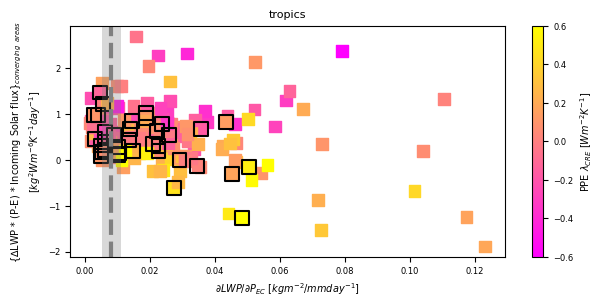

In [18]:
lat_ranges = [(0, 20, 'tropics')]

fig = plt.figure(figsize=(17.8/2.54, 3))
ax = fig.add_subplot()

for idx, (min_lat, max_lat, regime) in enumerate(lat_ranges):
    dLWP_TSmap_sel = sel_regime(dLWP_TSmap,min_lat,max_lat)
    convergence_mask_sel = sel_regime(convergence_mask,min_lat,max_lat)
    SWD_da_sel = sel_regime(SWD_da,min_lat,max_lat)
    cf_sel = sel_regime(cf,min_lat,max_lat)

    dLWP_TSmap_sel_mean = lat_weight_mean(dLWP_TSmap_sel)[0]
    convergence_mask_sel_mean = lat_weight_mean(convergence_mask_sel)[0]
    SWD_da_sel_mean = lat_weight_mean(SWD_da_sel)[0]
    cf_mean, cf_sem, cf_std = lat_weight_mean(cf_sel)
    conv_filter = convergence_mask_sel*SWD_da_sel
    filter_conv = lat_weight_mean(conv_filter)[0]

    final_data_n = {
        "xmap": pe_metric,
        "ymap1": dLWP_TSmap_sel_mean,
        "ymap2": convergence_mask_sel_mean,
        "ymap3": SWD_da_sel_mean,
        "clrmap": cf_mean,
        "filter": filtered_TOA_15,
        "filter2": filter_conv,
    }
    keys = list(final_data_n.keys())
    common_members = final_data_n[keys[0]]['runs'].values
    for name in keys:
        common_members = np.intersect1d(common_members, final_data_n[name]['runs'].values)
    final_data = {name: ds.sel(runs=common_members) for name, ds in final_data_n.items()}

    sel_merra_conv_sw = sel_regime(merra_conv_sw, min_lat, max_lat)
    merraMC_mean, merraMC_sem, _ = lat_weight_mean(sel_merra_conv_sw)
    from scipy.stats import norm
    z_95 = norm.ppf(0.975)
    obs_constraint_lower = merraMC_mean.values - z_95 * merraMC_sem.values
    obs_constraint_upper = merraMC_mean.values + z_95 * merraMC_sem.values

    PPE_conv_SWD = final_data['filter2']
    constrained = (PPE_conv_SWD.values >= obs_constraint_lower) & (PPE_conv_SWD.values <= obs_constraint_upper)

    x_p = final_data['xmap']
    y_p1 = final_data['ymap1']
    y_p2 = final_data['ymap2']
    y_p3 = final_data['ymap3']
    y_p = y_p1*y_p2*y_p3
    c_p = final_data['clrmap']

    pe_constrained = (x_p >= lower_pe_metric) & (x_p <= upper_pe_metric)
    conv_constrained = (y_p2*y_p3 >= obs_constraint_lower) & (y_p2*y_p3 <= obs_constraint_upper)
    both_constrained = pe_constrained & conv_constrained
    P_new_constrained = c_p[both_constrained]

    p_img = ax.scatter(x_p, y_p, c=c_p, 
                    cmap='spring', marker='s', s=72, vmin=-0.6, vmax=0.6)
    ax.scatter(x_p.sel(runs=constrained), y_p.sel(runs=constrained), 
               edgecolor='black', facecolor='none', marker='s', s=100, linewidth=1.5)
    ax.axvline(x=obs_pe_metric, color='grey', linestyle='--')
    ax.axvspan(lower_pe_metric, upper_pe_metric, facecolor='grey', alpha=0.3)
    ax.set_xlabel(xtitle+' $[kgm^{-2}/mmday^{-1}]$', fontsize=label_fontsize)
    ax.set_ylabel('{∆LWP * (P-E) * Incoming Solar flux}$_{converging}$ $_{areas}$\n$[kg^2Wm^{-6}K^{-1}day^{-1}]$', fontsize=label_fontsize)
    ax.set_title(regime, fontsize=title_fontsize)
    ax.tick_params(axis='both', labelsize=tick_fontsize)

    cbar = plt.colorbar(p_img, orientation='vertical')
    cbar.set_label('PPE $\\lambda_{CRE}$ $[Wm^{-2}K^{-1}]$', fontsize=label_fontsize)
    cbar.ax.tick_params(labelsize=tick_fontsize)

plt.savefig('final_figures/tropics.png',
            bbox_inches='tight', facecolor='white', dpi=600)

In [30]:
# def plot_PPE_MC_timeseries(fnum):
### downwelling SW at TOA
varnms = ['FSNTOA']
var_data = {}
runval='PD'
fnum = 0
fnums = f"{fnum:03d}"
WD='/glade/campaign/cgd/projects/ppe/cam_ppe/rerun_PPE_250/'+runval+'/'+runval+'_timeseries/'
for varnm in varnms:
    fn=WD+'PPE_250_ensemble_'+runval+'.'+fnums+'/atm/hist/cc_PPE_250_ensemble_'+runval+'.'+fnums+'.h0.'+varnm+'.nc'
    f = xr.open_dataset(fn)
    Z = f[varnm]
    Z = Z.assign_coords(lon=(((Z.lon + 180) % 360) - 180))
    Z = Z.sortby('lon')
    
    var_data[varnm] = {'Z': Z.data}
    print(varnm)



FSNTOA


In [27]:
FSNTOA = var_data['FSNTOA']['Z']
FSUTOA = var_data['FSUTOA']['Z']

In [29]:
f

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 36)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 0001-01-16 12:00:00 ... 0003-12-16 12:00:00
Data variables:
    FSUTOA   (time, lat, lon) float32 ...

In [31]:
f

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 36)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 0001-01-16 12:00:00 ... 0003-12-16 12:00:00
Data variables:
    FSNTOA   (time, lat, lon) float32 ...